In [1]:
1 + 1

2

In [5]:
import pandas as pd

#Load Data

films = pd.read_csv('film_data/movies.csv')

metadata = pd.read_csv('film_data/movies_metadata.csv')

ratings = pd.read_csv("film_data/ratings.csv")

films['title'] = films['title'].str[:-7] #early cleaning needed to be able to join on movie titles

#Merge Tables

new_merge =  films.merge(metadata, left_on='title', right_on='original_title', how='inner')

final_merge = new_merge.merge(ratings, on='movieId', how='inner')


/var/folders/j8/qk3qs96x2mg8j_pp6thc7r280000gn/T/ipykernel_24537/2803436445.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('film_data/movies_metadata.csv')


In [7]:
#CLEAN/PreProcess Data

# convert some predictors to appropriate formats

# Encode genres_x

import sklearn as sk
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
final_merge['genres_x_encoded'] = label_encoder.fit_transform(final_merge['genres_x'])
final_merge['release_year'] = pd.to_datetime(final_merge['release_date']).dt.year
final_merge.dropna(subset=['release_year'], inplace=True)
final_merge['release_year'] = final_merge['release_year'].astype(int)
final_merge['popularity'] = final_merge['popularity'].astype(float).astype(int)

In [8]:
# Beginning a subset for working on local machine. Start with aggregating duplicate ratings. 

df_agg = final_merge.groupby(['movieId', 'userId']).agg({'rating': 'mean', 'popularity': 'mean', 'runtime': 'mean', 'release_year': 'mean', 'genres_x_encoded': 'mean', 'vote_count': 'mean'}).reset_index()

df_sorted = df_agg.sort_values('popularity', ascending=False)

subset_df = df_sorted.head(6000000)

In [9]:
#SPLIT the data/Testing dimensionality changes


train_path = subset_df.sample(frac=0.8, random_state=42)
test_path = subset_df.drop(train_path.index)

sub_df = train_path
sub_df.head()

,movieId,userId,rating,popularity,runtime,release_year,genres_x_encoded,vote_count
12118503,8972,313,2.0,18.0,131.0,2004.0,82.0,1974.0
1550498,316,128664,3.5,13.0,121.0,1994.0,120.0,942.0
630042,110,20896,4.0,20.0,177.0,1995.0,290.0,3404.0
7578257,2572,65777,5.0,12.0,97.0,1999.0,755.0,1768.0
5950226,1717,123352,3.0,11.0,120.0,1997.0,736.0,856.0


### Content-Filtered Recommender

In [10]:
### testing model with metadata as predictors and ratings as response
# Feature selection
x_train = train_path[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
y_train = train_path['rating']
x_test = test_path[['userId', 'movieId', 'runtime', 'release_year', 'genres_x_encoded', 'popularity', 'vote_count']]
y_test = test_path['rating']

In [12]:
import xgboost as xgb

model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(x_train, y_train)

# Make predictions on the test data
pred1 = model1.predict(x_test)


In [ ]:
# Calculate the root mean squared error (RMSE)
rmseContent = np.sqrt(np.mean((pred1 - y_test)**2))
print(f'content-based rmse = {rmseContent}')

In [13]:
import numpy as np 

rmseContent = np.sqrt(np.mean((pred1 - y_test)**2))
print(f'content-based rmse = {rmseContent}')

content-based rmse = 0.9323691642794597


### Collaborative-Filtered Recommender

In [14]:
#pivot dataframe to utility matrix
utility = subset_df.pivot(index='movieId', columns='userId', values='rating')
utility = utility.fillna(0)
utility.head()

userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,0.0,5.0,0.0,3.0,0.0,0.0,2.0,0.0,3.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
utility.reset_index()

In [16]:
#condensed distance matrix

from scipy.spatial.distance import pdist, squareform
distance_mtx = squareform(pdist(utility, 'cosine'))

#a square matrix where each element represents the cosine similarity between movie and user rating.

similarity_mtx = 1 - distance_mtx

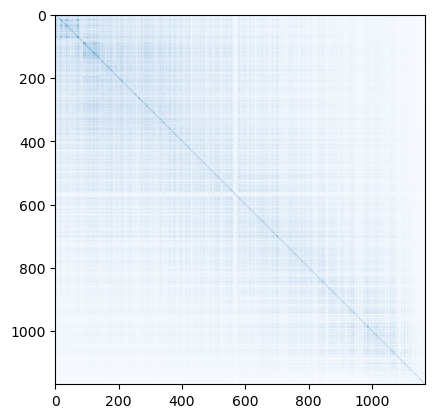

In [19]:
import matplotlib.pyplot as plt

plt.imshow(similarity_mtx, cmap = 'Blues')

In [20]:
#select ratings of a userId and the similarity scores for a movieId
user_to_predict = 10
movie_to_predict = 1

user_ratings = utility.iloc[:, user_to_predict-1]
movie_similarity = similarity_mtx[movie_to_predict-1]

In [21]:
#begin predictions

numerator = np.dot(user_ratings, movie_similarity)
denominator = movie_similarity[user_ratings > 0].sum() #removing 0 ratings if any left
pred_score = numerator / denominator

pred_score

#prediction is 3.93 vs actual rating of 4.0

3.933976199574737

In [22]:
#turn prediction into function
def predict_rating(userId, movieId, similarity_mtx, utility):
    #user_ratingsX = utilityX.iloc[:, userId-1]
    user_ratings = utility[userId]
    movie_index = list(utility.index).index(movieId)
    movie_similarity = similarity_mtx[movie_index]
    numerate = np.dot(user_ratings, movie_similarity)
    denom = movie_similarity[user_ratings > 0].sum()
    
    if denom == 0 or numerate == 0:
        return user_ratings[user_ratings > 0].mean()
    
    return numerate / denom

predict_rating(10,1, similarity_mtx, utility)

3.933976199574737

In [23]:
#testing the model

test_set = test_path[['userId', 'movieId']].to_numpy()
test_real = test_path['rating'].to_numpy()

In [24]:
pred = []
for data in test_set:
    res = predict_rating(data[0], data[1], similarity_mtx, utility)
    pred.append(res)

In [25]:
rmseCollab = np.sqrt(np.mean((test_real - pred)**2))
print(f'RMSE = {rmseCollab}')

RMSE = 0.856445077985479


### Hybrid System

In [26]:
# Convert pred1 and pred2 to NumPy arrays
pred1 = np.array(pred1)
pred = np.array(pred)

In [27]:
#Initially used an array to test different weight. 
chart_val = []
weights = np.linspace(0, 1, 21)

for weight in weights:
    pred_hybrid = pred1 * weight + pred * (1 - weight)
    rmse_hybrid = np.sqrt(np.mean((pred_hybrid - test_real)**2))
    chart_val.append([weight, rmse_hybrid])

chart_val_np = np.array(chart_val)

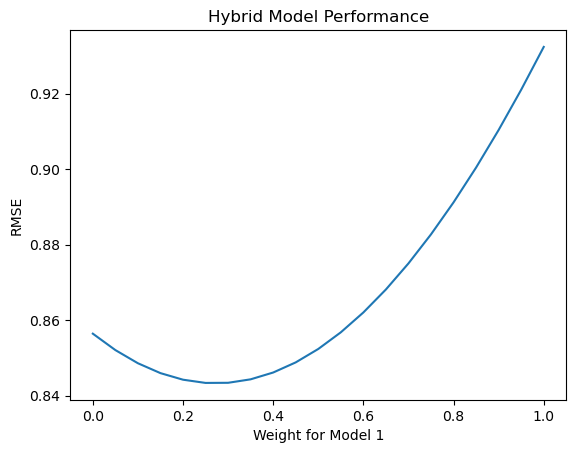

In [28]:
plt.plot(chart_val_np[:, 0], chart_val_np[:, 1])
plt.xlabel('Weight for Model 1')
plt.ylabel('RMSE')
plt.title('Hybrid Model Performance')
plt.show()

In [29]:
#plot shows hybrid performs best when model 1 is weighted at 0.3, model is adjusted accordingly.

w1 = 0.3
w2 = 1 - w1

hybrid_mod = pred1 * w1 + pred * w2

In [30]:
rmseHybrid = np.sqrt(np.mean((test_real - hybrid_mod)**2))
print(f'Content RMSE = {rmseContent}')
print(f'Collab RMSE = {rmseCollab}')
print(f'Hybrid RMSE = {rmseHybrid}')
#the recommender learns new information from each model and ultimately is the most accurate with a combination of both methods. 

Content RMSE = 0.9323691642794597
Collab RMSE = 0.856445077985479
Hybrid RMSE = 0.843434241235442
